This notebook loads a pre-trained PFN network and attacks it with the fast-gradient-sign-method (FGSM).  Additionally, a network is trained that computes a set of high-level observables as a bottleneck in the network:

(jet constituents) $\rightarrow$ (high-level observables) $\rightarrow$ (fully connected network) $\rightarrow$ (0,1)

In both cases, the attack is performed at the level of jet constituents.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

In [3]:
import keras
import keras.backend as K
import keras.layers as layers
from keras.models import Model
from keras.utils import to_categorical
from keras import callbacks

Using TensorFlow backend.


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from sklearn.metrics import roc_auc_score

In [5]:
import util, defs, models

In [6]:
import energyflow as ef
from energyflow.archs import PFN

In [7]:
bg_consts, sig_consts, bg_jets, sig_jets = util.load_data()
    
print(bg_consts.shape)
print(sig_consts.shape)

(118293, 96, 3)
(78604, 96, 3)


In [8]:
(X_train, y_train), (X_val, y_val) = util.format_dataset(bg_consts, sig_consts,
                                                         validation_fraction=defs.VALIDATION_FRACTION)

print("Training set:  ", X_train.shape)
print("Validation set:", X_val.shape)

Training set:   (133628, 96, 3)
Validation set: (23580, 96, 3)


In [9]:
K.clear_session()

In [10]:
benchmark_LL_PFN = keras.models.load_model('model_benchmark_PFN.h5',custom_objects={"tf":tf})

In [11]:
print("Validation AUC:", roc_auc_score(y_val, benchmark_LL_PFN.predict(X_val)))

Validation AUC: 0.8160260632600046


In [12]:
benchmark_LL_PFN2 = keras.models.load_model('model_benchmark_PFN.h5',custom_objects={"tf":tf})

In [15]:
#The model has a one-node output; it was easier for the FGSM to make it a two-node output
#(e.g. as if trained with categorical cross-entropy)

from keras.layers import Lambda
from keras.models import Sequential
def to_categorical_layer(x):
    return K.concatenate([1.-x, x], axis=1)

intermediatebit = Sequential()
intermediatebit.add(Lambda(to_categorical_layer))

wrapper = Model(inputs=benchmark_LL_PFN2.input,outputs=intermediatebit(benchmark_LL_PFN2.output))

In [16]:
wrapper.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 96, 3)             0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 96, 4)             0         
_________________________________________________________________
model_1 (Model)              (None, 1)                 462081    
_________________________________________________________________
sequential_1 (Sequential)    (None, 2)                 0         
Total params: 462,081
Trainable params: 462,081
Non-trainable params: 0
_________________________________________________________________


Now time for FGSM

In [24]:
njet = 6000
target_class = 1

use_sign = True

target_name = ['bg', 'signal'][target_class]
other_name = ['signal','bg'][target_class]

x_NN = X_val[y_val==target_class][:njet]
x_adv_NN = x_NN.copy()
x_noise_NN = np.zeros_like(x_NN)

prediction_history_NN     = [wrapper.predict(x_NN)[:,target_class].mean()]
prediction_history_quant_NN = [np.percentile(wrapper.predict(x_NN)[:,target_class],100*np.array([0.5,0.68,0.95]))]

In [25]:
#epsilons = (2e-4,2e-3,2e-3)
epsilons = (1e-5,2e-5,2e-5)
nstep = 100

sess = K.get_session()
epsilon = K.reshape(K.constant(epsilons), (1,1,3))
for istep in range(nstep):
    print("FGSM %d/%d..."%(istep+1,nstep))
    loss = -1*K.categorical_crossentropy(to_categorical((target_class+1)%2,2), wrapper.get_output_at(0))
    grads = K.gradients(loss, wrapper.get_input_at(0))
    
    if use_sign:
        delta = K.sign(grads[0])
    else:
        delta = grads[0]
    x_noise_NN = x_noise_NN + delta
    
    delta = tf.multiply(delta,tf.sign(tf.cast(x_NN,tf.float32))**2) #don't let it make new constituents
    x_adv_NN = x_adv_NN + epsilon*delta
    x_adv_NN = sess.run(x_adv_NN, feed_dict={wrapper.get_input_at(0):x_NN})
    preds = wrapper.predict(x_adv_NN)[:,target_class]
    prediction_history_NN.append(preds.mean())
    prediction_history_quant_NN.append(np.percentile(preds, 100*np.array([0.5,0.68,0.9])))
    print("  avg:", preds.mean())

FGSM 1/100...
  avg: 0.65195006
FGSM 2/100...
  avg: 0.65142393
FGSM 3/100...
  avg: 0.6508999
FGSM 4/100...
  avg: 0.65037733
FGSM 5/100...
  avg: 0.64985603
FGSM 6/100...
  avg: 0.6493368
FGSM 7/100...
  avg: 0.6488188
FGSM 8/100...
  avg: 0.6483026
FGSM 9/100...
  avg: 0.64778876
FGSM 10/100...
  avg: 0.6472783
FGSM 11/100...
  avg: 0.64677024
FGSM 12/100...
  avg: 0.6462653
FGSM 13/100...
  avg: 0.6457637
FGSM 14/100...
  avg: 0.6452644
FGSM 15/100...
  avg: 0.644768
FGSM 16/100...
  avg: 0.6442742
FGSM 17/100...
  avg: 0.6437819
FGSM 18/100...
  avg: 0.6432916
FGSM 19/100...
  avg: 0.64280427
FGSM 20/100...
  avg: 0.64231956
FGSM 21/100...
  avg: 0.64183694
FGSM 22/100...
  avg: 0.6413566
FGSM 23/100...
  avg: 0.6408789
FGSM 24/100...
  avg: 0.6404034
FGSM 25/100...
  avg: 0.6399298
FGSM 26/100...
  avg: 0.63945764
FGSM 27/100...
  avg: 0.63898677
FGSM 28/100...
  avg: 0.63851714
FGSM 29/100...
  avg: 0.63804966
FGSM 30/100...
  avg: 0.6375839
FGSM 31/100...
  avg: 0.63712
FGSM 32

In [26]:
x_adv_NN_predict = wrapper.predict(x_adv_NN)

In [27]:
backs = benchmark_LL_PFN.predict(X_val[y_val==0])
sigs = benchmark_LL_PFN.predict(X_val[y_val==1])

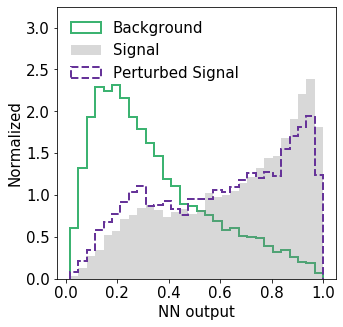

In [28]:
plt.rc('xtick',labelsize=15)
plt.rc('ytick',labelsize=15)
plt.figure(figsize=(5,5))
n,b,_=plt.hist(x_adv_NN_predict[:,1],density=True,histtype='step',bins=30,color='rebeccapurple',linestyle="--",linewidth=2.0)
n2,_,_=plt.hist(backs,density=True,bins=b,histtype='step',color='mediumseagreen',label="Background",linewidth=2.0)
_,_,_=plt.hist(sigs,density=True,bins=b,color='gray',alpha=0.3,label="Signal")
_,_,_=plt.hist(x_adv_NN_predict[:,1],density=True,histtype='step',bins=b,color='rebeccapurple',linestyle="--",label="Perturbed Signal",linewidth=2.0)
plt.ylim([0,max(n2)*1.4])
plt.xlabel('NN output',fontsize=15)
plt.ylabel('Normalized',fontsize=15)
plt.legend(frameon=False,fontsize=15)

In [29]:
from sklearn.metrics import roc_curve
preds_LL_PFN = benchmark_LL_PFN.predict(X_val)
fpr_LL_PFN, tpr_LL_PFN, _ = roc_curve(y_val, 1-preds_LL_PFN)

preds_NN_adv = wrapper.predict(x_adv_NN)
fprNN_adv, tprNN_adv, _ = roc_curve(np.concatenate([y_val[y_val!=target_class],np.ones(len(preds_NN_adv))]),np.concatenate([np.reshape(1-preds_LL_PFN[y_val!=target_class],[len(preds_LL_PFN[y_val!=target_class])]),1-preds_NN_adv[:,1]]))

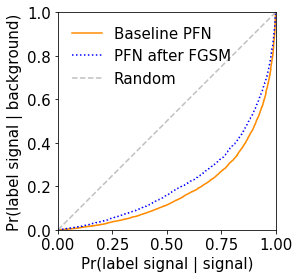

In [30]:
plt.axes().set_aspect('equal')
plt.plot(fpr_LL_PFN,tpr_LL_PFN,color='darkorange',label=r'Baseline PFN')
plt.plot(fprNN_adv,tprNN_adv,color='blue',label=r'PFN after FGSM',linestyle=":")
plt.plot([0,1],[0,1],linestyle='--',color="#C0C0C0",label="Random")
plt.xlabel('Pr(label signal | signal)',fontsize=15)
plt.ylabel('Pr(label signal | background)',fontsize=15)
plt.axis([0, 1, 0, 1])
plt.legend(loc='upper left',frameon=False,fontsize=15)
plt.show()

In [31]:
#This is the numpy version of the tensorflow function in util.py
def mymass_numpy(x):
    #this one takes _consts without any modification.
    pT,eta,phi=np.split(x,3,axis=2) #axis = 2 because it is a list of particles, then a list of properties per particle
    jpx = np.sum(pT*np.cos(phi),axis=1)
    jpy = np.sum(pT*np.sin(phi),axis=1)
    jpz = np.sum(pT*(0.5*(np.exp(eta)-np.exp(-eta))),axis=1) #no tf.sinh in my version
    jpE = np.sum(pT*(0.5*(np.exp(eta)+np.exp(-eta))),axis=1) #no tf.cosh in my version
    jet_m2 = jpE**2-jpx**2-jpy**2-jpz**2
    jet_mass = np.sqrt(np.where(jet_m2>0,jet_m2,np.zeros_like(jet_m2))) #m
    return jet_mass #m

In [32]:
m_backs = mymass_numpy(X_val[y_val==0])*1000
m_signal = mymass_numpy(X_val[y_val==1])*1000
m_signal_advs = mymass_numpy(x_adv_NN)*1000

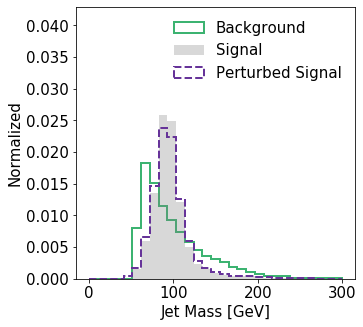

In [33]:
plt.rc('xtick',labelsize=15)
plt.rc('ytick',labelsize=15)
plt.figure(figsize=(5,5))
n,b,_=plt.hist(m_signal_advs,density=True,histtype='step',bins=np.linspace(0,300,30),color='rebeccapurple',linestyle="--",linewidth=2.0)
_,_,_=plt.hist(m_backs,density=True,bins=b,histtype='step',color='mediumseagreen',label="Background",linewidth=2.0)
_,_,_=plt.hist(m_signal,density=True,bins=b,color='gray',alpha=0.3,label="Signal")
_,_,_=plt.hist(m_signal_advs,density=True,histtype='step',bins=b,color='rebeccapurple',linestyle="--",label="Perturbed Signal",linewidth=2.0)
plt.ylim([0,max(n)*1.8])
plt.xlabel('Jet Mass [GeV]',fontsize=15)
plt.ylabel('Normalized',fontsize=15)
plt.legend(frameon=False,fontsize=15)

Now, let's contrast this with the network trained on high-level observables (inside a FCN).

In [34]:
benchmark_HL_nonaug, benchmark_HL_aug, benchmark_HL_calc = models.mk_benchmark_HL(**defs.BENCHMARK_HL_ARGS)

In [35]:
benchmark_HL_calc.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 96, 3)             0         
_________________________________________________________________
model_4 (Model)              (None, 4)                 0         
_________________________________________________________________
model_2 (Model)              (None, 1)                 297985    
Total params: 297,985
Trainable params: 297,985
Non-trainable params: 0
_________________________________________________________________


In [36]:
epochs = 50

batch_size = 256

learning_rate = 3e-4

K.set_value(benchmark_HL_calc.optimizer.lr, learning_rate)

stopping = callbacks.EarlyStopping(monitor='val_loss', patience=32, verbose=1,
                                   mode='min', restore_best_weights=True)

try:
    benchmark_HL_calc.fit(X_train, y_train,
                     validation_data=(X_val, y_val),
                     batch_size=batch_size,
                     epochs=epochs
                    )
except KeyboardInterrupt:
    pass

Train on 133628 samples, validate on 23580 samples
Epoch 1/50
133628/133628 [==============================] - 27s 199us/step - loss: 0.6660 - val_loss: 0.6436
Epoch 2/50
133628/133628 [==============================] - 17s 125us/step - loss: 0.6420 - val_loss: 0.6167
Epoch 3/50
133628/133628 [==============================] - 17s 125us/step - loss: 0.6108 - val_loss: 0.5780
Epoch 4/50
133628/133628 [==============================] - 17s 125us/step - loss: 0.5791 - val_loss: 0.5591
Epoch 5/50
133628/133628 [==============================] - 17s 125us/step - loss: 0.5689 - val_loss: 0.5570
Epoch 6/50
133628/133628 [==============================] - 17s 125us/step - loss: 0.5658 - val_loss: 0.5548
Epoch 7/50
133628/133628 [==============================] - 17s 125us/step - loss: 0.5642 - val_loss: 0.5558
Epoch 8/50
133628/133628 [==============================] - 17s 125us/step - loss: 0.5632 - val_loss: 0.5548
Epoch 9/50
133628/133628 [==============================] - 17s 125us/step - 

In [39]:
benchmark_HL_calc.save("model_benchmark_HL_calc.h5")

In [37]:
preds_val = benchmark_HL_calc.predict(X_val, batch_size=512).squeeze()

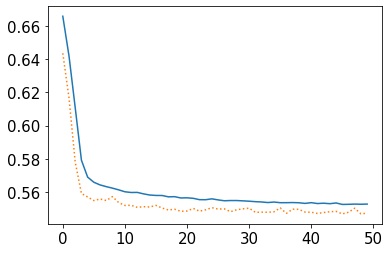

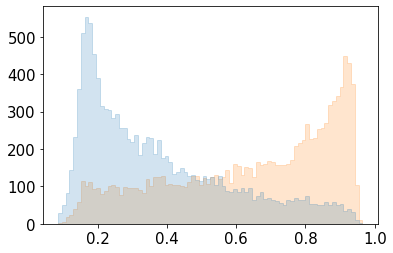

In [38]:
plt.plot(benchmark_HL_calc.history.history['loss'])
plt.plot(benchmark_HL_calc.history.history['val_loss'],linestyle=":")

plt.figure()
plt.hist([preds_val[y_val==0], preds_val[y_val==1]], histtype='step', bins=80, fill=True, alpha=0.2);

In [40]:
#The model has a one-node output; it was easier for the FGSM to make it a two-node output
#(e.g. as if trained with categorical cross-entropy)

intermediatebit_HL = Sequential()
intermediatebit_HL.add(Lambda(to_categorical_layer))

wrapper_HL = Model(inputs=benchmark_HL_calc.input,outputs=intermediatebit_HL(benchmark_HL_calc.output))

In [41]:
njet_HL = 500

x_NN_HL = X_val[y_val==target_class][:njet_HL]
x_adv_NN_HL = x_NN_HL.copy()
x_noise_NN_HL = np.zeros_like(x_NN_HL)

prediction_history_NN_HL     = [wrapper_HL.predict(x_NN_HL)[:,target_class].mean()]
prediction_history_quant_NN_HL = [np.percentile(wrapper_HL.predict(x_NN_HL)[:,target_class],100*np.array([0.5,0.68,0.95]))]

In [42]:
epsilons = (1e-5,2e-5,2e-5)
nstep = 100

sess = K.get_session()
epsilon = K.reshape(K.constant(epsilons), (1,1,3))
for istep in range(nstep):
    print("FGSM %d/%d..."%(istep+1,nstep))
    loss = -1*K.categorical_crossentropy(to_categorical((target_class+1)%2,2), wrapper_HL.get_output_at(0))
    grads = K.gradients(loss, wrapper_HL.get_input_at(0))
    
    if use_sign:
        delta = K.sign(grads[0])
    else:
        delta = grads[0]
    x_noise_NN_HL = x_noise_NN_HL + delta
    
    delta = tf.multiply(delta,tf.sign(tf.cast(x_NN_HL,tf.float32))**2) #don't let it make new constituents
    x_adv_NN_HL = x_adv_NN_HL + epsilon*delta
    x_adv_NN_HL = sess.run(x_adv_NN_HL, feed_dict={wrapper_HL.get_input_at(0):x_NN_HL})
    preds = wrapper_HL.predict(x_adv_NN_HL)[:,target_class]
    prediction_history_NN_HL.append(preds.mean())
    prediction_history_quant_NN_HL.append(np.percentile(preds, 100*np.array([0.5,0.68,0.9])))
    print("  avg:", preds.mean())

FGSM 1/100...
  avg: 0.64393485
FGSM 2/100...
  avg: 0.6423902
FGSM 3/100...
  avg: 0.6408401
FGSM 4/100...
  avg: 0.6392843
FGSM 5/100...
  avg: 0.63772374
FGSM 6/100...
  avg: 0.6361528
FGSM 7/100...
  avg: 0.63456607
FGSM 8/100...
  avg: 0.63297766
FGSM 9/100...
  avg: 0.6313854
FGSM 10/100...
  avg: 0.629794
FGSM 11/100...
  avg: 0.628204
FGSM 12/100...
  avg: 0.6266116
FGSM 13/100...
  avg: 0.625021
FGSM 14/100...
  avg: 0.62343127
FGSM 15/100...
  avg: 0.62184435
FGSM 16/100...
  avg: 0.62025476
FGSM 17/100...
  avg: 0.61866397
FGSM 18/100...
  avg: 0.61707395
FGSM 19/100...
  avg: 0.6154841
FGSM 20/100...
  avg: 0.6138978
FGSM 21/100...
  avg: 0.61231244
FGSM 22/100...
  avg: 0.61072636
FGSM 23/100...
  avg: 0.6091466
FGSM 24/100...
  avg: 0.6075736
FGSM 25/100...
  avg: 0.6060015
FGSM 26/100...
  avg: 0.6044316
FGSM 27/100...
  avg: 0.6028657
FGSM 28/100...
  avg: 0.601298
FGSM 29/100...
  avg: 0.59973156
FGSM 30/100...
  avg: 0.5981742
FGSM 31/100...
  avg: 0.5966191
FGSM 32/1

In [43]:
x_adv_NN_HL_predict = wrapper_HL.predict(x_adv_NN_HL)

In [44]:
backs_HL = wrapper_HL.predict(X_val[y_val==0])
sigs_HL = wrapper_HL.predict(X_val[y_val==1])

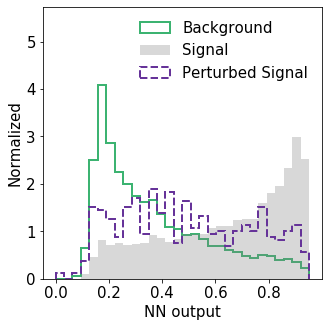

In [45]:
plt.rc('xtick',labelsize=15)
plt.rc('ytick',labelsize=15)
plt.figure(figsize=(5,5))
n,b,_=plt.hist(x_adv_NN_HL_predict[:,1],density=True,histtype='step',bins=30,color='rebeccapurple',linestyle="--",linewidth=2.0)
n2,_,_=plt.hist(backs_HL[:,1],density=True,bins=b,histtype='step',color='mediumseagreen',label="Background",linewidth=2.0)
_,_,_=plt.hist(sigs_HL[:,1],density=True,bins=b,color='gray',alpha=0.3,label="Signal")
_,_,_=plt.hist(x_adv_NN_HL_predict[:,1],density=True,histtype='step',bins=b,color='rebeccapurple',linestyle="--",label="Perturbed Signal",linewidth=2.0)
plt.ylim([0,max(n2)*1.4])
plt.xlabel('NN output',fontsize=15)
plt.ylabel('Normalized',fontsize=15)
plt.legend(frameon=False,fontsize=15)

In [46]:
preds_HL = wrapper_HL.predict(X_val)
fpr_HL, tpr_HL, _ = roc_curve(y_val, 1-preds_HL[:,1])

preds_NN_HL_adv = wrapper_HL.predict(x_adv_NN_HL)
fprNN_HL_adv, tprNN_HL_adv, _ = roc_curve(np.concatenate([y_val[y_val!=target_class],np.ones(len(preds_NN_HL_adv))]),np.concatenate([np.reshape(1-preds_HL[y_val!=target_class][:,1],[len(preds_HL[y_val!=target_class][:,1])]),1-preds_NN_HL_adv[:,1]]))

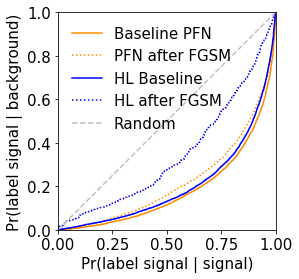

In [47]:
plt.axes().set_aspect('equal')
plt.plot(fpr_LL_PFN,tpr_LL_PFN,color='darkorange',label=r'Baseline PFN')
plt.plot(fprNN_adv,tprNN_adv,color='darkorange',label=r'PFN after FGSM',linestyle=":")
plt.plot(fpr_HL,tpr_HL,color='blue',label=r'HL Baseline')
plt.plot(fprNN_HL_adv,tprNN_HL_adv,color='blue',label=r'HL after FGSM',linestyle=":")
plt.plot([0,1],[0,1],linestyle='--',color="#C0C0C0",label="Random")
plt.xlabel('Pr(label signal | signal)',fontsize=15)
plt.ylabel('Pr(label signal | background)',fontsize=15)
plt.axis([0, 1, 0, 1])
plt.legend(loc='upper left',frameon=False,fontsize=15)
plt.show()

In [48]:
m_signal_advs_HL = mymass_numpy(x_adv_NN_HL)*1000

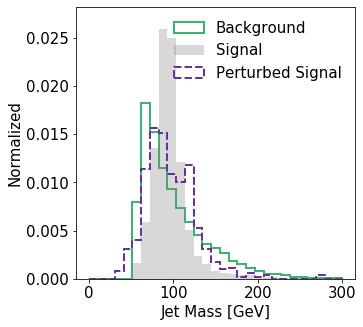

In [49]:
plt.rc('xtick',labelsize=15)
plt.rc('ytick',labelsize=15)
plt.figure(figsize=(5,5))
n,b,_=plt.hist(m_signal_advs_HL,density=True,histtype='step',bins=np.linspace(0,300,30),color='rebeccapurple',linestyle="--",linewidth=2.0)
_,_,_=plt.hist(m_backs,density=True,bins=b,histtype='step',color='mediumseagreen',label="Background",linewidth=2.0)
_,_,_=plt.hist(m_signal,density=True,bins=b,color='gray',alpha=0.3,label="Signal")
_,_,_=plt.hist(m_signal_advs_HL,density=True,histtype='step',bins=b,color='rebeccapurple',linestyle="--",label="Perturbed Signal",linewidth=2.0)
plt.ylim([0,max(n)*1.8])
plt.xlabel('Jet Mass [GeV]',fontsize=15)
plt.ylabel('Normalized',fontsize=15)
plt.legend(frameon=False,fontsize=15)